In [16]:
from sklearn.decomposition import PCA
from scipy import sparse
import pickle
import pandas as pd

from Constants import *
import matplotlib.pyplot as plt

newspaper_speaker_tfidf = sparse.load_npz(FILE_NEWSPAPER_SPEAKER_TFIDF)
X = newspaper_speaker_tfidf.toarray()

In [2]:
with open(PICKLE_NEWSPAPER_TO_INDEX, 'rb') as handle:
    newspaper_to_index = pickle.load(handle)

with open(PICKLE_INDEX_TO_NEWSPAPER, 'rb') as handle:
    index_to_newspaper = pickle.load(handle)

In [3]:
bound_x = int (X.shape[0]/3)
selected_X = X[:bound_x]
selected_newspaper = [index_to_newspaper[i] for i in range(bound_x)]

In [4]:
import random

colors = [random.randint(0,5) for newspaper in selected_newspaper]


In [5]:
pca = PCA(n_components=2)
Y = pca.fit_transform(selected_X)

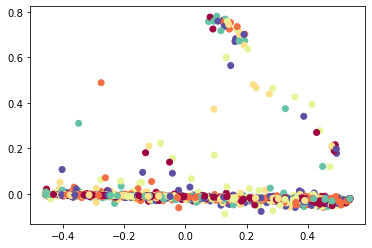

In [6]:
plt.scatter(Y[:, 0], Y[:, 1], c=colors, cmap=plt.cm.Spectral)
plt.show()

In [8]:
newspaper_toekn_tfidf = sparse.load_npz(FILE_NEWSPAPER_TOKEN_TFIDF)
Z = newspaper_toekn_tfidf.toarray()

In [41]:
bound_z = int (Z.shape[0]/3)
selected_Z = Z[:bound_z]
selected_newspaper_z = [index_to_newspaper[i] for i in range(bound_z)]
colors_z = [random.randint(0,6) for newspaper in selected_newspaper_z]

In [ ]:
pca_z = PCA(n_components=2)
Y_z = pca_z.fit_transform(selected_Z)

plt.scatter(Y_z[:, 0],Y_z[:, 1], c=colors_z, cmap=plt.cm.Spectral)
plt.show()

In [42]:
df = pd.DataFrame(
    {
        "x": Y_z[:, 0],
        "y": Y_z[:, 1],
        "group": [str(c) for c in colors_z]
    }
)

In [43]:
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import d3
import bokeh.models as bmo
import bokeh.plotting as bpl

In [44]:
source = bpl.ColumnDataSource(df)

# use whatever palette you want...
palette = d3['Category10'][len(df['group'].unique())]
color_map = bmo.CategoricalColorMapper(factors=df['group'].unique(),palette=palette)

# create figure and plot
p = bpl.figure()
p.scatter(x='x', y='y',
          color={'field': 'group', 'transform': color_map},
          legend='group', source=source)

bpl.show(p)
